In [1]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install equadratures # for standard pip install

# Machine learning of airfoil self-noise with interpretable polynomial trees

The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. 

<img src="images/airfoil_noise.png" alt="drawing" style="width:450px;"/>


[UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/airfoil+self-noise)

Feature      | Description                            | Units
:------------|:---------------------------------------|:-----:
$f$          | Frequency                              | Hz
$\alpha$     | Angle of attack                        | Degrees
$U_{\infty}$ | Free-stream velocity                   | m
$C$          | Airfoil chord length                   | m/s
$\delta^*$   | Suction side boundary layer thickness  | m


Output is SPL, the scaled sound pressure level, in decibels.


In [2]:
import numpy as np                                                                                                                                                                                      
import equadratures as eq
import pandas as pd
import matplotlib.pyplot as plt

random_state = 4
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat',delimiter='\t',
                  names=['Frequency','AoA','Chord','Velocity','Thickness','spl'])
y = data.spl.to_numpy()
X = data.drop('spl',axis = 1).to_numpy()
X_train, X_test, y_train, y_test = eq.datasets.train_test_split(X, y, train=0.75, \
                                                                random_seed=random_state)

In [3]:
# Define a helper scorer/plotting function
def test_model(model):
    ypred_train = model.predict(X_train)
    ypred_test  = model.predict(X_test)
     
    fig, ax = plt.subplots()
    ax.plot(y_train,ypred_train,'o',alpha=0.6,mec='k',label='train')
    ax.plot(y_test,ypred_test,'o',alpha=0.6,mec='k',label='test')
    ax.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)],
            'k--',zorder=10,lw=2)
    ax.set_aspect(1)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xlim([np.min(y_test),np.max(y_test)])
    ax.set_ylim([np.min(y_test),np.max(y_test)])
    ax.grid('on')
    ax.legend()    
    plt.show()

    print('Training MAE = %.2f' %(eq.datasets.score(y_train,ypred_train,'mae')))
    print('Test MAE = %.2f' %(eq.datasets.score(y_test,ypred_test,'mae')))

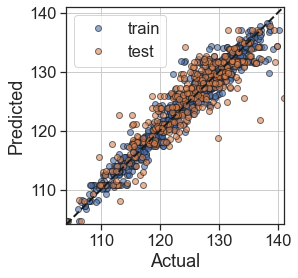

Training MAE = 1.10
Test MAE = 2.23


In [4]:
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor(criterion='mse',max_depth=10,
                           min_samples_leaf=2,random_state=random_state)
DT.fit(X_train,y_train)
test_model(DT)

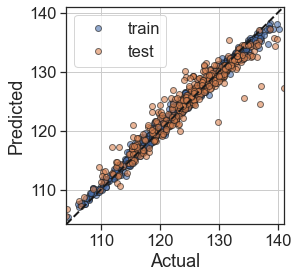

Training MAE = 0.50
Test MAE = 1.42


In [5]:
from sklearn.ensemble import RandomForestRegressor
# Random forest with fully grown trees
RF = RandomForestRegressor(n_estimators=100,criterion='mse',max_depth=None,
                           random_state=random_state)
RF.fit(X_train,y_train)
test_model(RF)

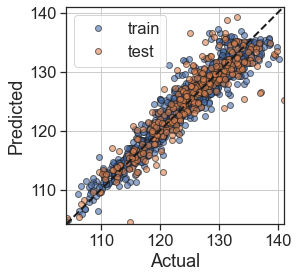

Training MAE = 1.49
Test MAE = 1.94


In [6]:
order = 3        #or deeper tree with order=1
max_depth = 3

tree = eq.PolyTree(splitting_criterion='loss_gradient', max_depth=max_depth, 
                    order=order, poly_method='elastic-net',
             poly_solver_args={'max_iter':20,'verbose':False,'alpha':1.0,'nlambdas':20,
                         'crit':'CV'})

tree.fit(X_train,y_train)

test_model(tree)

## References
[1]: Brooks, T. F., Pope, D. S.,  and Marcolini A. M. (1989), Airfoil self-noise and prediction. Technical report, NASA RP-1218.